## FluxInfer RCA from Sock Shop dataset

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict, OrderedDict
import pathlib

import numpy as np
import pandas as pd
import torch
import torchinfo
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)

import sys
sys.path.append("../")

In [3]:
from notebooklib.save import run_tsdr, save_tsdr, load_tsdr

DATASET_ID = "qknmc"
datasets_hdsbcan_sbd = load_tsdr(DATASET_ID, revert_normalized_time_series=True)
datasets_fluxrank_max_cluster = load_tsdr(DATASET_ID, suffix="fluxrank_max_cluster", revert_normalized_time_series=True)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [38]:
from itertools import combinations
from typing import Callable

import networkx as nx
from scipy import stats

import diagnoser.metric_node as mn
from diagnoser import diag

def fisher_z(dm, cm, x, y) -> float:
    m = dm.shape[0]
    r = cm[x, y]
    if 1 - r == 0:
        r = 1 - 1e-10
    if r >= 1.0:
        r = 1.0 - 1e-10
    elif r <= -1.0:
        r = -1.0 + 1e-10
    z = np.log((1 + r) / (1 - r))
    zstat = np.sqrt(m - 3) * 0.5 * np.abs(z)
    p_val = 2.0 * scipy.stats.norm.cdf(np.abs(zstat))
    return p_val

# no gsq
def g_sq(dm: np.ndarray, cm: np.ndarray, x: int, y: int) -> float:
    obs = dm[[x, y]]
    np.place(obs, obs == 0.0, 1e-30)
    chi, p_value, dof, expected = stats.chi2_contingency(
        obs, lambda_="log-likelihood",
    )
    return p_value

def build_wudg(pk, data_df: pd.DataFrame, init_graph_type="complete", citest="fisher-z") -> nx.Graph:
    nodes = mn.MetricNodes.from_dataframe(data_df)
    g: nx.Graph
    match init_graph_type:
        case "complete":
            g = nx.Graph()
            for (u, v) in combinations(nodes, 2):
                g.add_edge(u, v)
        case "nw_call":
            g = diag.prepare_init_graph(nodes, pk)
        case _:
            assert False, f"Unknown init_graph_type: {init_graph_type}"
    
    citest_func: Callable
    match citest:
        case "fisher-z":
            dm = data_df.to_numpy(dtype=np.float32)
            cm = np.corrcoef(dm.T)
            citest_func = fisher_z 
        case "gsq":
            dm = data_df.to_numpy(dtype=np.float32).T
            cm = np.array([])
            citest_func = g_sq
        case _:
            raise ValueError(f"Unknown citest: {citest}")

    _g = nx.relabel_nodes(g, mapping=nodes.node_to_num)
    for (u, v) in _g.edges:
        p_val = citest_func(dm, cm, u, v)
        _g[u][v]['weight'] = 1 / p_val if p_val != 0.0 else sys.float_info.max

    return nx.relabel_nodes(_g, mapping=nodes.num_to_node)


def build_wudg_and_pagerank(
    record,
    reduced_df,
    init_graph_type="nw_call",
    citest="fisher-z",
    directed_edge: bool = False,
    personalized: bool = False,
):
    reduced_df = reduced_df.where(reduced_df >= 0.0, 0.0)
    try:
        wudg: nx.Graph = build_wudg(record.pk, reduced_df, init_graph_type=init_graph_type, citest=citest)
    except ValueError as e:
        print(e)
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            print(reduced_df.loc[:, reduced_df.apply(lambda x: np.any((x.to_numpy() < 0.0)), axis=0)])
        return []
    if directed_edge:
        wudg = diag.fix_edge_directions_in_causal_graph(wudg, pk)
    pr = nx.pagerank(wudg, alpha=0.85)
    _records = []
    for metric_name, rank in pr.items():
        _records.append((DATASET_ID, record.target_app(), record.chaos_type(), record.chaos_comp(), str(metric_name), record.data_df[str(metric_name)].values, rank))
    return _records


from itertools import chain

from pandas.core.groupby import DataFrameGroupBy

from eval.groundtruth import check_cause_metrics
from diagnoser.metric_node import MetricNodes
from meltria.priorknowledge.priorknowledge import SockShopKnowledge

from meltria.priorknowledge.priorknowledge import SockShopKnowledge
from diagnoser.metric_node import MetricNodes, MetricNode

pk = SockShopKnowledge(
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewalres": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}},
)

def get_ranks_by_case(sorted_results_df: DataFrameGroupBy, pk: SockShopKnowledge, granularity: str = "metric"):
    ranks_by_case: dict[str, dict[str, list[int]]] = defaultdict(lambda: defaultdict(list))
    n_cases: int = 0
    for (dataset_id, target_app, chaos_type, chaos_comp), group in sorted_results_df:
        if chaos_comp == "queue-master":
            continue
        metrics = [str(m) for m in group["metric"].values.tolist()]
        ranks: list[int]
        match granularity:
            case "metric":
                ok, cause_metrics = check_cause_metrics(
                    pk, metrics, chaos_type=chaos_type, chaos_comp=chaos_comp, optional_cause=True,
                )
                if not ok or len(cause_metrics) == 0:
                    print(f"no cause metrics: {dataset_id}, {target_app}, {chaos_type}, {chaos_comp}")
                    continue
                metrics = [m for m in metrics if not m.startswith("s-")] # Exclude service metrics
                ranked_metrics = MetricNodes.from_metric_names(metrics)
                ranks = sorted([list(ranked_metrics).index(cm) + 1 for cm in cause_metrics])
            case "container":
                metrics = [m for m in metrics if not m.startswith("s-")] # Exclude service metrics
                ranked_ctnrs = dict.fromkeys([pk.get_container_by_metric(metric) for metric in metrics])
                ranks = sorted([i+1 for i, ctnr in enumerate(ranked_ctnrs) if ctnr == chaos_comp])
            case "service":
                chaos_service: str = pk.get_service_by_container(chaos_comp)
                ranked_service = dict.fromkeys([pk.get_service_by_metric(metric) for metric in metrics])
                ranked_service = [s for s in ranked_service if s is not None and not s.startswith("gke-")]
                ranks = sorted([i+1 for i, service in enumerate(ranked_service) if service == chaos_service])
            case _:
                assert False, f"Unknown detect_unit: {granularity}"
        ranks_by_case[chaos_type][chaos_comp] = ranks
        n_cases += 1
    return ranks_by_case, n_cases


def calc_ac_k(k: int, ranks_by_case: dict[str, dict[str, list[int]]], n_faults: int) -> float:
    ac_a: list[float] = []
    sum_ac = 0.0
    for chaos_type, ranks_by_ in ranks_by_case.items():
        for chaos_comp, ranks in ranks_by_.items():
            if (min_param := min(k, len(ranks)) > 0):
                sum_ac += sum([1 if ranks[i-1] <= k else 0 for i in range(1, min_param+1)]) / min_param
    return sum_ac / n_faults


def evaluate_ac_of_rc(
    sorted_results_df: DataFrameGroupBy, pk: SockShopKnowledge, k: int = 10, granuallity: str = "metric",
) -> pd.DataFrame:
    top_k_set = range(1, k+1)
    ranks_by_case, n_cases = get_ranks_by_case(sorted_results_df, pk, granularity=granuallity)
    ac_k = {k: calc_ac_k(k, ranks_by_case, n_cases) for k in top_k_set}
    avg_k = {k: sum([ac_k[j] for j in range(1, k+1)]) / k for k in top_k_set}
    return pd.concat([pd.DataFrame(ac_k, index=[f"AC@K ({granuallity})"]).T, pd.DataFrame(avg_k, index=[f"AVG@K ({granuallity})"]).T], axis=1)

In [39]:
import joblib

_list_of_records = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_wudg_and_pagerank)(record, reduced_df, init_graph_type="nw_call", citest="fisher-z", directed_edge=False) for record, _, anomalous_df, reduced_df in datasets_fluxrank_max_cluster)
ranked_datasets = sum(_list_of_records, [])  # flatten

ranked_df_max_cluster = pd.DataFrame(ranked_datasets, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp", "metric", "time_series", "rank"])
sorted_results_df = ranked_df_max_cluster.query("not metric.str.startswith('n-')", engine='python').loc[:, ranked_df_max_cluster.columns != "time_series"].dropna(subset=["rank"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(sorted_results_df.head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

/tmp/ipykernel_402435/3319646760.py:61: RuntimeWarning: overflow encountered in double_scalars
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,
/tmp/ipykernel_402435/3319646760.py:61: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3319646760.py:61: RuntimeWarning: overflow encountered in double_scalars
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,
/tmp/ipykernel_402435/3319646760.py:61: RuntimeWarning: overflow encountered in double_scalars
/home/ubuntu/src/git

metric  \
dataset_id target_app chaos_type       chaos_comp                                                                                                           
qknmc      sock-shop  pod-network-loss user-db                                                                             c-user_cpu_usage_seconds_total   
                                       user-db                                                                     c-catalogue-db_cpu_usage_seconds_total   
                                       user-db                                                                        c-catalogue_cpu_usage_seconds_total   
                                       user-db                                                                               c-user-db_memory_usage_bytes   
                                       user-db                                                                         c-user-db_memory_working_set_bytes   
                                       user-db                                                                              c-user_cpu_user_seconds_total   
                                       user-db                                                                      c-catalogue-db_cpu_user_seconds_total   
                                       user-db                                                                          c-catalogue_cpu_cfs_periods_total   
                                       user-db                                                                        m-orders-db_mongodb_sys_cpu_idle_ms   
                                       user-db                                                                        m-orders-db_mongodb_sys_cpu_user_ms   
                                       user                                                                            c-carts-db_cpu_usage_seconds_total   
                                       user                                                                             c-carts-db_cpu_user_seconds_total   
                                       user                                                                              c-orders_cpu_usage_seconds_total   
                                       user                                                                                c-user_cpu_usage_seconds_total   
                                       user                                                                             c-user-db_cpu_usage_seconds_total   
                                       user                                                                             c-payment_cpu_usage_seconds_total   
                                       user                                                                               c-payment_cpu_cfs_periods_total   
                                       user                                                                               c-orders_cpu_user_seconds_total   
                                       user                                                                                 c-user_cpu_user_seconds_total   
                                       user                                                                              c-user-db_cpu_user_seconds_total   
                                       payment                                                           m-orders_java_lang_OperatingSystem_SystemCpuLoad   
                                       payment                                                                                       s-payment_throughput   
                                       payment                                                            m-carts_java_lang_OperatingSystem_SystemCpuLoad   
                                       payment                                                                            c-user_memory_working_set_bytes   
                                       payment                   

In [40]:
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None, "display.precision", 2):
    display(
        pd.concat([
            evaluate_ac_of_rc(sorted_results_df, pk, k=10, granuallity="metric"),
            evaluate_ac_of_rc(sorted_results_df, pk, k=10, granuallity="container"),
            evaluate_ac_of_rc(sorted_results_df, pk, k=10, granuallity="service"),
        ], axis=1)
    )

no cause metrics: qknmc, sock-shop, pod-memory-hog, catalogue
no cause metrics: qknmc, sock-shop, pod-memory-hog, orders
no cause metrics: qknmc, sock-shop, pod-memory-hog, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, catalogue
no cause metrics: qknmc, sock-shop, pod-network-loss, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, user-db


AC@K (metric)  AVG@K (metric)  AC@K (container)  AVG@K (container)  \
1            0.04            0.04              0.21               0.21   
2            0.04            0.04              0.31               0.26   
3            0.04            0.04              0.52               0.34   
4            0.04            0.04              0.59               0.41   
5            0.09            0.05              0.76               0.48   
6            0.09            0.06              0.86               0.54   
7            0.09            0.06              0.86               0.59   
8            0.09            0.07              0.86               0.62   
9            0.09            0.07              0.90               0.65   
10           0.13            0.07              0.93               0.68   

    AC@K (service)  AVG@K (service)  
1             0.21             0.21  
2             0.41             0.31  
3             0.66             0.43  
4             0.83             0.53  
5             0.83             0.59  
6             0.93             0.64  
7             1.00             0.69  
8             1.00             0.73  
9             1.00             0.76  
10            1.00             0.79

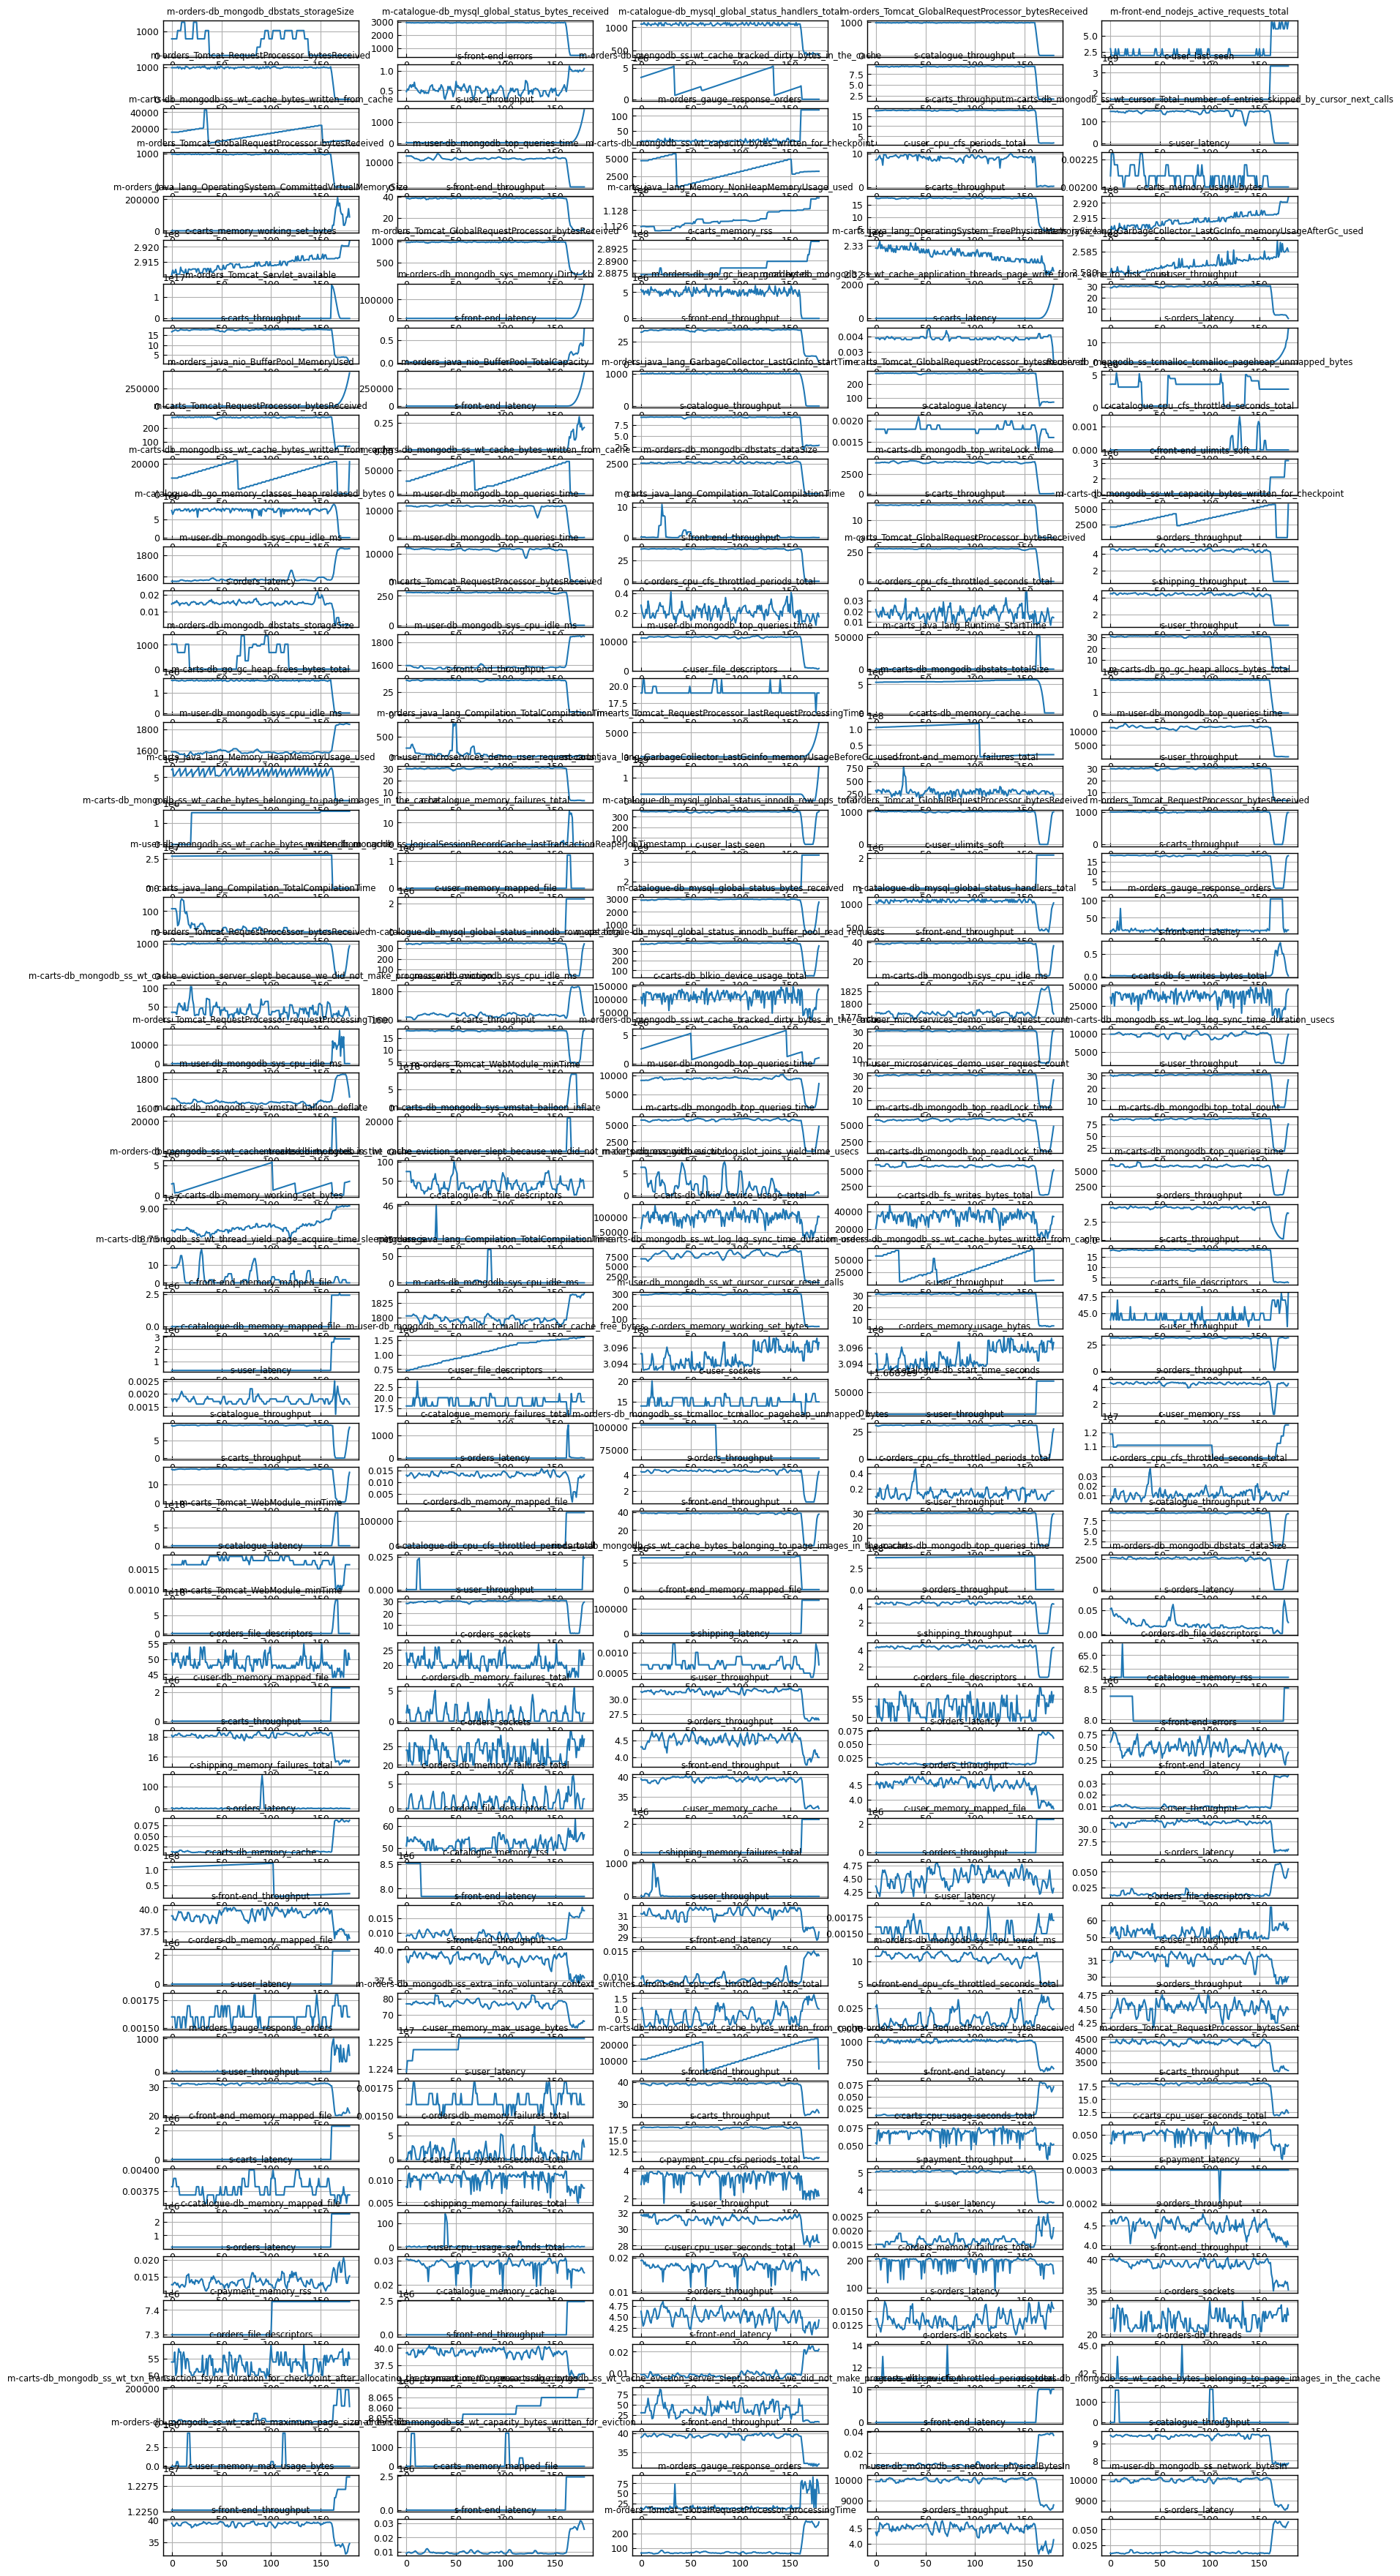

In [7]:
import math

_sorted_results_df = ranked_df_max_cluster.query("not metric.str.startswith('n-')", engine='python').sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"]).head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"])

fig = plt.figure(figsize=(20, 45))
axs = fig.subplots(nrows=math.ceil(_sorted_results_df.shape[0] / 5), ncols=5)
for ax, row in zip(axs.flatten(), _sorted_results_df.itertuples()):
    ax.plot(row.time_series)
    ax.set_title(row.metric)

## 3-Phase reduction

In [8]:
from tsdr import tsdr

def _hier_clustering(pk, data_df: pd.DataFrame, dist_type="sbd"):
    _, clustering_info = tsdr.Tsdr("residual_integral", **{
        "step2_clustering_method_name": "hierarchy",
        "step2_hierarchy_dist_threshold": 0.02,  # should be <1.0 if 'sbd' is specified
        "step2_hierarchy_dist_type": dist_type,  # 'pearsonr' or 'sbd'
        "step2_hierarchy_linkage_method": "single",  # 'single','complete','average','weighted', 'centroid', 'median', 'ward'
        "step2_clustering_series_type": "raw",  # 'raw', 'anomaly_score' or 'binary_anomaly_score'
        "step2_clustering_choice_method": 'medoid',  # 'medoid' or 'maxsum'
    }).reduce_multivariate_series(data_df.apply(scipy.stats.zscore), pk, n_workers=1)
    return data_df[list(clustering_info.keys())]

def _hdbscan_clustering(pk, data_df: pd.DataFrame, dist_type="sbd"):
    _, clustering_info = tsdr.Tsdr("residual_integral", **{
        "step2_clustering_method_name": "dbscan",
        "step2_dbscan_min_pts": 1,
        "step2_dbscan_dist_type": dist_type,  # 'pearsonr' or 'sbd'
        "step2_dbscan_algorithm": "hdbscan",  # 'dbscan' or 'hdbscan'
        "step2_clustering_series_type": "raw",  # 'raw', 'anomaly_score' or 'binary_anomaly_score'
        "step2_clustering_choice_method": 'medoid',  # 'medoid' or 'maxsum'
    }).reduce_multivariate_series(data_df.apply(scipy.stats.zscore), pk, n_workers=1)
    return data_df[list(clustering_info.keys())]

In [9]:
datasets_fluxrank_max_cluster_with_3phase = []
for record, filtered_df, anomalous_df, reduced_df in datasets_fluxrank_max_cluster:
    _df = _hier_clustering(record.pk, reduced_df)
    datasets_fluxrank_max_cluster_with_3phase.append((record, filtered_df, anomalous_df, reduced_df, _df))

In [10]:
for record, filtered_df, anomalous_df, reduced_df, more_reduced_df in datasets_fluxrank_max_cluster_with_3phase:
    # _df = _hier_clustering(record.pk, reduced_df)
    if record.chaos_type() == "pod-cpu-hog" and record.chaos_comp() in ["user"]:
        print(reduced_df.columns)

Index(['c-carts-db_cpu_cfs_throttled_seconds_total', 'c-catalogue_memory_rss',
       'c-carts_threads', 'c-carts-db_cpu_cfs_throttled_periods_total',
       'c-catalogue-db_cpu_cfs_throttled_seconds_total',
       'c-front-end_memory_rss',
       'c-catalogue-db_cpu_cfs_throttled_periods_total',
       'c-front-end_memory_usage_bytes', 'c-orders_file_descriptors',
       'c-front-end_memory_working_set_bytes', 'c-orders_sockets',
       'c-orders-db_memory_failures_total', 'c-payment_file_descriptors',
       'c-shipping_memory_failures_total', 'c-payment_sockets',
       'c-user_file_descriptors', 'c-user_cpu_user_seconds_total',
       'c-user_memory_max_usage_bytes',
       'c-user_cpu_cfs_throttled_seconds_total', 'c-user_memory_rss',
       'c-user_memory_cache', 'c-user_cpu_cfs_throttled_periods_total',
       'c-user_memory_usage_bytes', 'c-user-db_cpu_system_seconds_total',
       'c-user_threads', 'c-user_processes', 'c-user_memory_working_set_bytes',
       'c-user_cpu_usage

In [11]:
_list_of_records = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_wudg_and_pagerank)(record, reduced_df, init_graph_type="nw_call") for record, _, _, _, reduced_df in datasets_fluxrank_max_cluster_with_3phase)
ranked_datasets_with_3phase = sum(_list_of_records, [])  # flatten

/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars


In [12]:
ranked_df = pd.DataFrame(ranked_datasets_with_3phase, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp", "metric", "time_series", "rank"])
sorted_results_df_with_3phase = ranked_df.query("not metric.str.startswith('n-')", engine='python').loc[:, ranked_df.columns != "time_series"].dropna(subset=["rank"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(sorted_results_df_with_3phase.head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

metric  \
dataset_id target_app chaos_type       chaos_comp                                                                                                            
qknmc      sock-shop  pod-network-loss user-db                                                                                      s-catalogue_throughput   
                                       user-db                                                       m-catalogue-db_mysql_global_status_created_tmp_tables   
                                       user-db                                                          m-orders-db_mongodb_ss_wt_block_manager_bytes_read   
                                       user-db                                 m-orders-db_mongodb_ss_wt_checkpoint_cleanup_pages_skipped_during_tree_walk   
                                       user-db                                                       m-orders-db_mongodb_ss_wt_block_manager_bytes_written   
                                       user-db                                                                         m-orders-db_mongodb_sys_cpu_idle_ms   
                                       user-db                                                                         c-catalogue_cpu_usage_seconds_total   
                                       user-db                                                                         m-orders-db_mongodb_sys_cpu_user_ms   
                                       user-db                     m-orders-db_mongodb_ss_wt_cache_application_threads_page_write_from_cache_to_disk_count   
                                       user-db                                                                                c-user-db_memory_usage_bytes   
                                       user                                                                                                 c-user_threads   
                                       user                                                                                 m-orders_gauge_response_orders   
                                       user                                                                                         s-catalogue_throughput   
                                       user                                                                                     c-carts-db_fs_writes_total   
                                       user                                                                              c-carts-db_cpu_user_seconds_total   
                                       user                                                                             m-carts-db_mongodb_sys_cpu_idle_ms   
                                       user                                                                m-carts-db_mongodb_ss_extra_info_system_time_us   
                                       user                                                     m-orders_java_lang_OperatingSystem_OpenFileDescriptorCount   
                                       user                                                                                     c-payment_file_descriptors   
                                       user                                                                              c-orders_cpu_system_seconds_total   
                                       payment                                                            m-orders_java_lang_OperatingSystem_SystemCpuLoad   
                                       payment                                                             m-carts_java_lang_OperatingSystem_SystemCpuLoad   
                                       payment                                                                         c-catalogue_cpu_usage_seconds_total   
                                       payment                                                                           c-catalogue_cpu_cfs_periods_total   
                                       p

In [13]:
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None, "display.precision", 2):
    display(
        pd.concat([
            evaluate_ac_of_rc(sorted_results_df_with_3phase, pk, k=10, granuallity="metric"),
            evaluate_ac_of_rc(sorted_results_df_with_3phase, pk, k=10, granuallity="container"),
            evaluate_ac_of_rc(sorted_results_df_with_3phase, pk, k=10, granuallity="service"),
        ], axis=1)
    )

no cause metrics: qknmc, sock-shop, pod-memory-hog, catalogue
no cause metrics: qknmc, sock-shop, pod-memory-hog, orders
no cause metrics: qknmc, sock-shop, pod-memory-hog, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, catalogue
no cause metrics: qknmc, sock-shop, pod-network-loss, orders-db
no cause metrics: qknmc, sock-shop, pod-network-loss, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, user-db


AC@K (metric)  AVG@K (metric)  AC@K (container)  AVG@K (container)  \
1            0.00            0.00              0.28               0.28   
2            0.09            0.05              0.48               0.38   
3            0.14            0.08              0.66               0.47   
4            0.14            0.09              0.83               0.56   
5            0.27            0.13              0.86               0.62   
6            0.27            0.15              0.90               0.67   
7            0.32            0.18              0.93               0.70   
8            0.41            0.20              0.93               0.73   
9            0.41            0.23              0.93               0.75   
10           0.41            0.25              0.93               0.77   

    AC@K (service)  AVG@K (service)  
1             0.28             0.28  
2             0.38             0.33  
3             0.69             0.45  
4             0.90             0.56  
5             0.97             0.64  
6             1.00             0.70  
7             1.00             0.74  
8             1.00             0.78  
9             1.00             0.80  
10            1.00             0.82

## Hierarychical localization

In [14]:
ranked_df = ranked_df.query("not metric.str.startswith('n-')", engine='python').loc[:, ranked_df.columns != "time_series"].dropna(subset=["rank"])
ranked_df["service"] = ranked_df.apply(lambda row: pk.get_service_by_metric(row.metric), axis=1)
ranked_df["container"] = ranked_df.apply(lambda row: pk.get_container_by_metric(row.metric), axis=1)
ranked_df

dataset_id target_app        chaos_type chaos_comp  \
0         qknmc  sock-shop       pod-cpu-hog      carts   
1         qknmc  sock-shop       pod-cpu-hog      carts   
2         qknmc  sock-shop       pod-cpu-hog      carts   
3         qknmc  sock-shop       pod-cpu-hog      carts   
4         qknmc  sock-shop       pod-cpu-hog      carts   
...         ...        ...               ...        ...   
2871      qknmc  sock-shop  pod-network-loss    user-db   
2872      qknmc  sock-shop  pod-network-loss    user-db   
2873      qknmc  sock-shop  pod-network-loss    user-db   
2874      qknmc  sock-shop  pod-network-loss    user-db   
2875      qknmc  sock-shop  pod-network-loss    user-db   

                                                 metric      rank service  \
0                                    s-carts_throughput  0.005263   carts   
1                                       s-carts_latency  0.023722   carts   
2                                     c-carts_processes  0.007299   carts   
3               c-carts_cpu_cfs_throttled_periods_total  0.012761   carts   
4                                       c-carts_sockets  0.002759   carts   
...                                                 ...       ...     ...   
2871  m-orders-db_mongodb_ss_wt_txn_transaction_fsyn...  0.015687  orders   
2872  m-orders-db_mongodb_ss_wt_cursor_cursor_create...  0.015662  orders   
2873                m-orders-db_mongodb_sys_cpu_idle_ms  0.030802  orders   
2874   m-orders-db_mongodb_sys_netstat_TcpExt_TCPHPHits  0.002349  orders   
2875  m-orders-db_mongodb_ss_wt_txn_transaction_chec...  0.023073  orders   

      container  
0          None  
1          None  
2         carts  
3         carts  
4         carts  
...         ...  
2871  orders-db  
2872  orders-db  
2873  orders-db  
2874  orders-db  
2875  orders-db  

[2301 rows x 8 columns]

In [15]:
mean_ranked_df_by_service =  ranked_df.groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp", "service"]).agg({"rank": "mean"}).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])

with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(mean_ranked_df_by_service.head(n=5))

rank
dataset_id target_app chaos_type       chaos_comp   service            
qknmc      sock-shop  pod-network-loss user-db      catalogue  0.018060
                                                    orders     0.010878
                                                    carts      0.009955
                                                    front-end  0.009734
                                                    user       0.009387
                                       user         catalogue  0.020350
                                                    user       0.014932
                                                    front-end  0.014204
                                                    orders     0.013984
                                                    carts      0.010711
                                       payment      front-end  0.022278
                                                    user       0.019303
                                                    catalogue  0.017746
                                                    payment    0.016310
                                                    orders     0.015090
                                       orders-db    carts      0.010228
                                                    orders     0.008053
                                                    front-end  0.007003
                                                    shipping   0.005795
                                                    user       0.004599
                                       orders       catalogue  0.019803
                                                    carts      0.019470
                                                    front-end  0.017682
                                                    orders     0.016119
                                                    user       0.012688
                                       catalogue-db user       0.009746
                                                    catalogue  0.009459
                                                    carts      0.008017
                                                    orders     0.007509
                                                    front-end  0.006410
                                       catalogue    user       0.032402
                                                    carts      0.015603
                                                    orders     0.015241
                                                    catalogue  0.014879
                                                    shipping   0.013704
                                       carts-db     carts      0.008833
                                                    orders     0.008173
                                                    catalogue  0.006812
                                                    front-end  0.004582
                                                    user       0.003331
                                       carts        orders     0.019628
                                                    front-end  0.017040
                                                    catalogue  0.013713
                                                    carts      0.013093
                                                    user       0.011786
                      pod-memory-hog   user-db      front-end  0.009609
                                                    carts      0.008458
                                                    user       0.007488
                                                    orders     0.006959
                                                    catalogue  0.005685
                                       user         user       0.015209
                                                    carts      0.013829
                                                    orders     0.011749
                                                    catalogue  0.009708
                                   

In [16]:
ranked_df["rank_order"] = ranked_df["rank"].rank(method="first")
mean_ranked_order_df_by_service = ranked_df.groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp", "service"]).agg({"rank_order": "mean"}).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank_order"], ascending=True).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])

with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(mean_ranked_order_df_by_service.head(n=10))

rank_order
dataset_id target_app chaos_type       chaos_comp   service               
qknmc      sock-shop  pod-cpu-hog      carts        catalogue   937.666667
                                                    carts      1162.266667
                                                    payment    1358.750000
                                                    user       1489.789474
                                                    orders     1567.466667
                                                    shipping   1717.500000
                                                    front-end  1823.750000
                                       carts-db     payment     805.500000
                                                    catalogue   841.750000
                                                    user        986.000000
                                                    carts      1070.239130
                                                    shipping   1078.333333
                                                    orders     1159.638298
                                                    front-end  1346.333333
                                       catalogue    payment    1012.000000
                                                    front-end  1422.333333
                                                    catalogue  1439.125000
                                                    shipping   1548.000000
                                                    orders     1613.500000
                                                    user       1622.250000
                                                    carts      1667.400000
                                       catalogue-db payment    1207.333333
                                                    catalogue  1326.428571
                                                    orders     1614.000000
                                                    user       1647.200000
                                                    shipping   1660.000000
                                                    carts      1783.800000
                                                    front-end  1994.500000
                                       front-end    front-end  1304.800000
                                                    shipping   1576.000000
                                                    catalogue  1652.500000
                                                    payment    1673.750000
                                                    carts      1834.000000
                                                    user       1852.666667
                                                    orders     1886.428571
                                       orders       front-end  1014.666667
                                                    shipping   1187.333333
                                                    catalogue  1254.500000
                                                    payment    1319.000000
                                                    orders     1421.647059
                                                    carts      1444.500000
                                                    user       1651.000000
                                       orders-db    payment     398.666667
                                                    shipping    459.333333
                                                    user        844.500000
                                                    catalogue  1155.428571
                                                    orders     1212.636364
                                                    carts      1479.500000
                                                    front-end  1608.000000
                                       payment      user       1050.250000
                                                    payment    1249.000000
                                                    catalogue  1476.750000
              

In [17]:
_list_of_records = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_wudg_and_pagerank)(record, reduced_df, init_graph_type="nw_call") for record, _, _, reduced_df in datasets_hdsbcan_sbd)
ranked_datasets = sum(_list_of_records, [])  # flatten

/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWar

### Only service metrics 

In [18]:
_sorted_results_df_only_service = ranked_df_max_cluster.query("metric.str.startswith('s-')", engine='python').loc[:, ranked_df_max_cluster.columns != "time_series"].dropna(subset=["rank"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(_sorted_results_df_only_service.head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

metric  \
dataset_id target_app chaos_type       chaos_comp                             
qknmc      sock-shop  pod-network-loss user-db           s-front-end_errors   
                                       user-db       s-catalogue_throughput   
                                       user-db          s-catalogue_latency   
                                       user-db           s-carts_throughput   
                                       user-db              s-carts_latency   
                                       user-db          s-orders_throughput   
                                       user-db             s-orders_latency   
                                       user-db               s-user_latency   
                                       user-db            s-user_throughput   
                                       user-db         s-payment_throughput   
                                       user               s-user_throughput   
                                       user              s-carts_throughput   
                                       user                  s-user_latency   
                                       user             s-orders_throughput   
                                       user                s-orders_latency   
                                       user                 s-carts_latency   
                                       user            s-payment_throughput   
                                       user               s-payment_latency   
                                       user          s-front-end_throughput   
                                       user           s-shipping_throughput   
                                       payment       s-front-end_throughput   
                                       payment           s-carts_throughput   
                                       payment         s-payment_throughput   
                                       payment              s-carts_latency   
                                       payment          s-front-end_latency   
                                       payment            s-payment_latency   
                                       payment       s-catalogue_throughput   
                                       payment            s-user_throughput   
                                       payment          s-catalogue_latency   
                                       payment          s-orders_throughput   
                                       orders-db          s-user_throughput   
                                       orders-db         s-carts_throughput   
                                       orders-db        s-front-end_latency   
                                       orders-db     s-front-end_throughput   
                                       orders-db            s-carts_latency   
                                       orders-db           s-orders_latency   
                                       orders-db        s-orders_throughput   
                                       orders-db       s-payment_throughput   
                                       orders-db          s-payment_latency   
                                       orders-db             s-user_latency   
                                       orders           s-front-end_latency   
                                       orders        s-catalogue_throughput   
                                       orders           s-catalogue_latency   
                                       orders             s-user_throughput   
                                       orders                s-user_latency   
                                       orders           s-orders_throughput   
                                       orders              s-orders_latency   
                                       orders            s-carts_throughput   
                                       orders               s-carts_latency   
                                       o

In [27]:
## build WUDG with only service metrics
def filter_service_metrics(df: pd.DataFrame) -> pd.DataFrame:
    return df.loc[:, df.columns.str.startswith("s-")]

_list_of_records = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_wudg_and_pagerank)(record, filter_service_metrics(reduced_df), init_graph_type="complete", citest="gsq") for record, _, _, reduced_df in datasets_fluxrank_max_cluster)
_ranked_datasets = sum(_list_of_records, [])  # flatten

_ranked_df = pd.DataFrame(_ranked_datasets, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp", "metric", "time_series", "rank"])

_sorted_results_df_only_service = _ranked_df.loc[:, _ranked_df.columns != "time_series"].dropna(subset=["rank"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(_sorted_results_df_only_service.head(n=5).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

metric  \
dataset_id target_app chaos_type       chaos_comp                             
qknmc      sock-shop  pod-network-loss user-db               s-user_latency   
                                       user-db            s-user_throughput   
                                       user-db           s-carts_throughput   
                                       user-db       s-catalogue_throughput   
                                       user-db         s-payment_throughput   
                                       user               s-user_throughput   
                                       user          s-catalogue_throughput   
                                       user          s-front-end_throughput   
                                       user            s-payment_throughput   
                                       user              s-carts_throughput   
                                       payment       s-catalogue_throughput   
                                       payment       s-front-end_throughput   
                                       payment           s-carts_throughput   
                                       payment          s-catalogue_latency   
                                       payment              s-carts_latency   
                                       orders-db           s-orders_latency   
                                       orders-db          s-user_throughput   
                                       orders-db     s-front-end_throughput   
                                       orders-db         s-carts_throughput   
                                       orders-db     s-catalogue_throughput   
                                       orders           s-orders_throughput   
                                       orders             s-user_throughput   
                                       orders            s-carts_throughput   
                                       orders        s-catalogue_throughput   
                                       orders          s-payment_throughput   
                                       catalogue-db     s-catalogue_latency   
                                       catalogue-db       s-user_throughput   
                                       catalogue-db      s-carts_throughput   
                                       catalogue-db  s-catalogue_throughput   
                                       catalogue-db    s-payment_throughput   
                                       catalogue         s-carts_throughput   
                                       catalogue     s-catalogue_throughput   
                                       catalogue            s-carts_latency   
                                       catalogue        s-catalogue_latency   
                                       catalogue     s-front-end_throughput   
                                       carts-db             s-carts_latency   
                                       carts-db      s-front-end_throughput   
                                       carts-db          s-carts_throughput   
                                       carts-db           s-user_throughput   
                                       carts-db      s-catalogue_throughput   
                                       carts            s-front-end_latency   
                                       carts             s-carts_throughput   
                                       carts         s-front-end_throughput   
                                       carts              s-user_throughput   
                                       carts         s-catalogue_throughput   
                      pod-memory-hog   user-db           s-front-end_errors   
                                       user-db            s-user_throughput   
                                       user-db           s-carts_throughput   
                                       user-db       s-catalogue_throughput   
                                       u

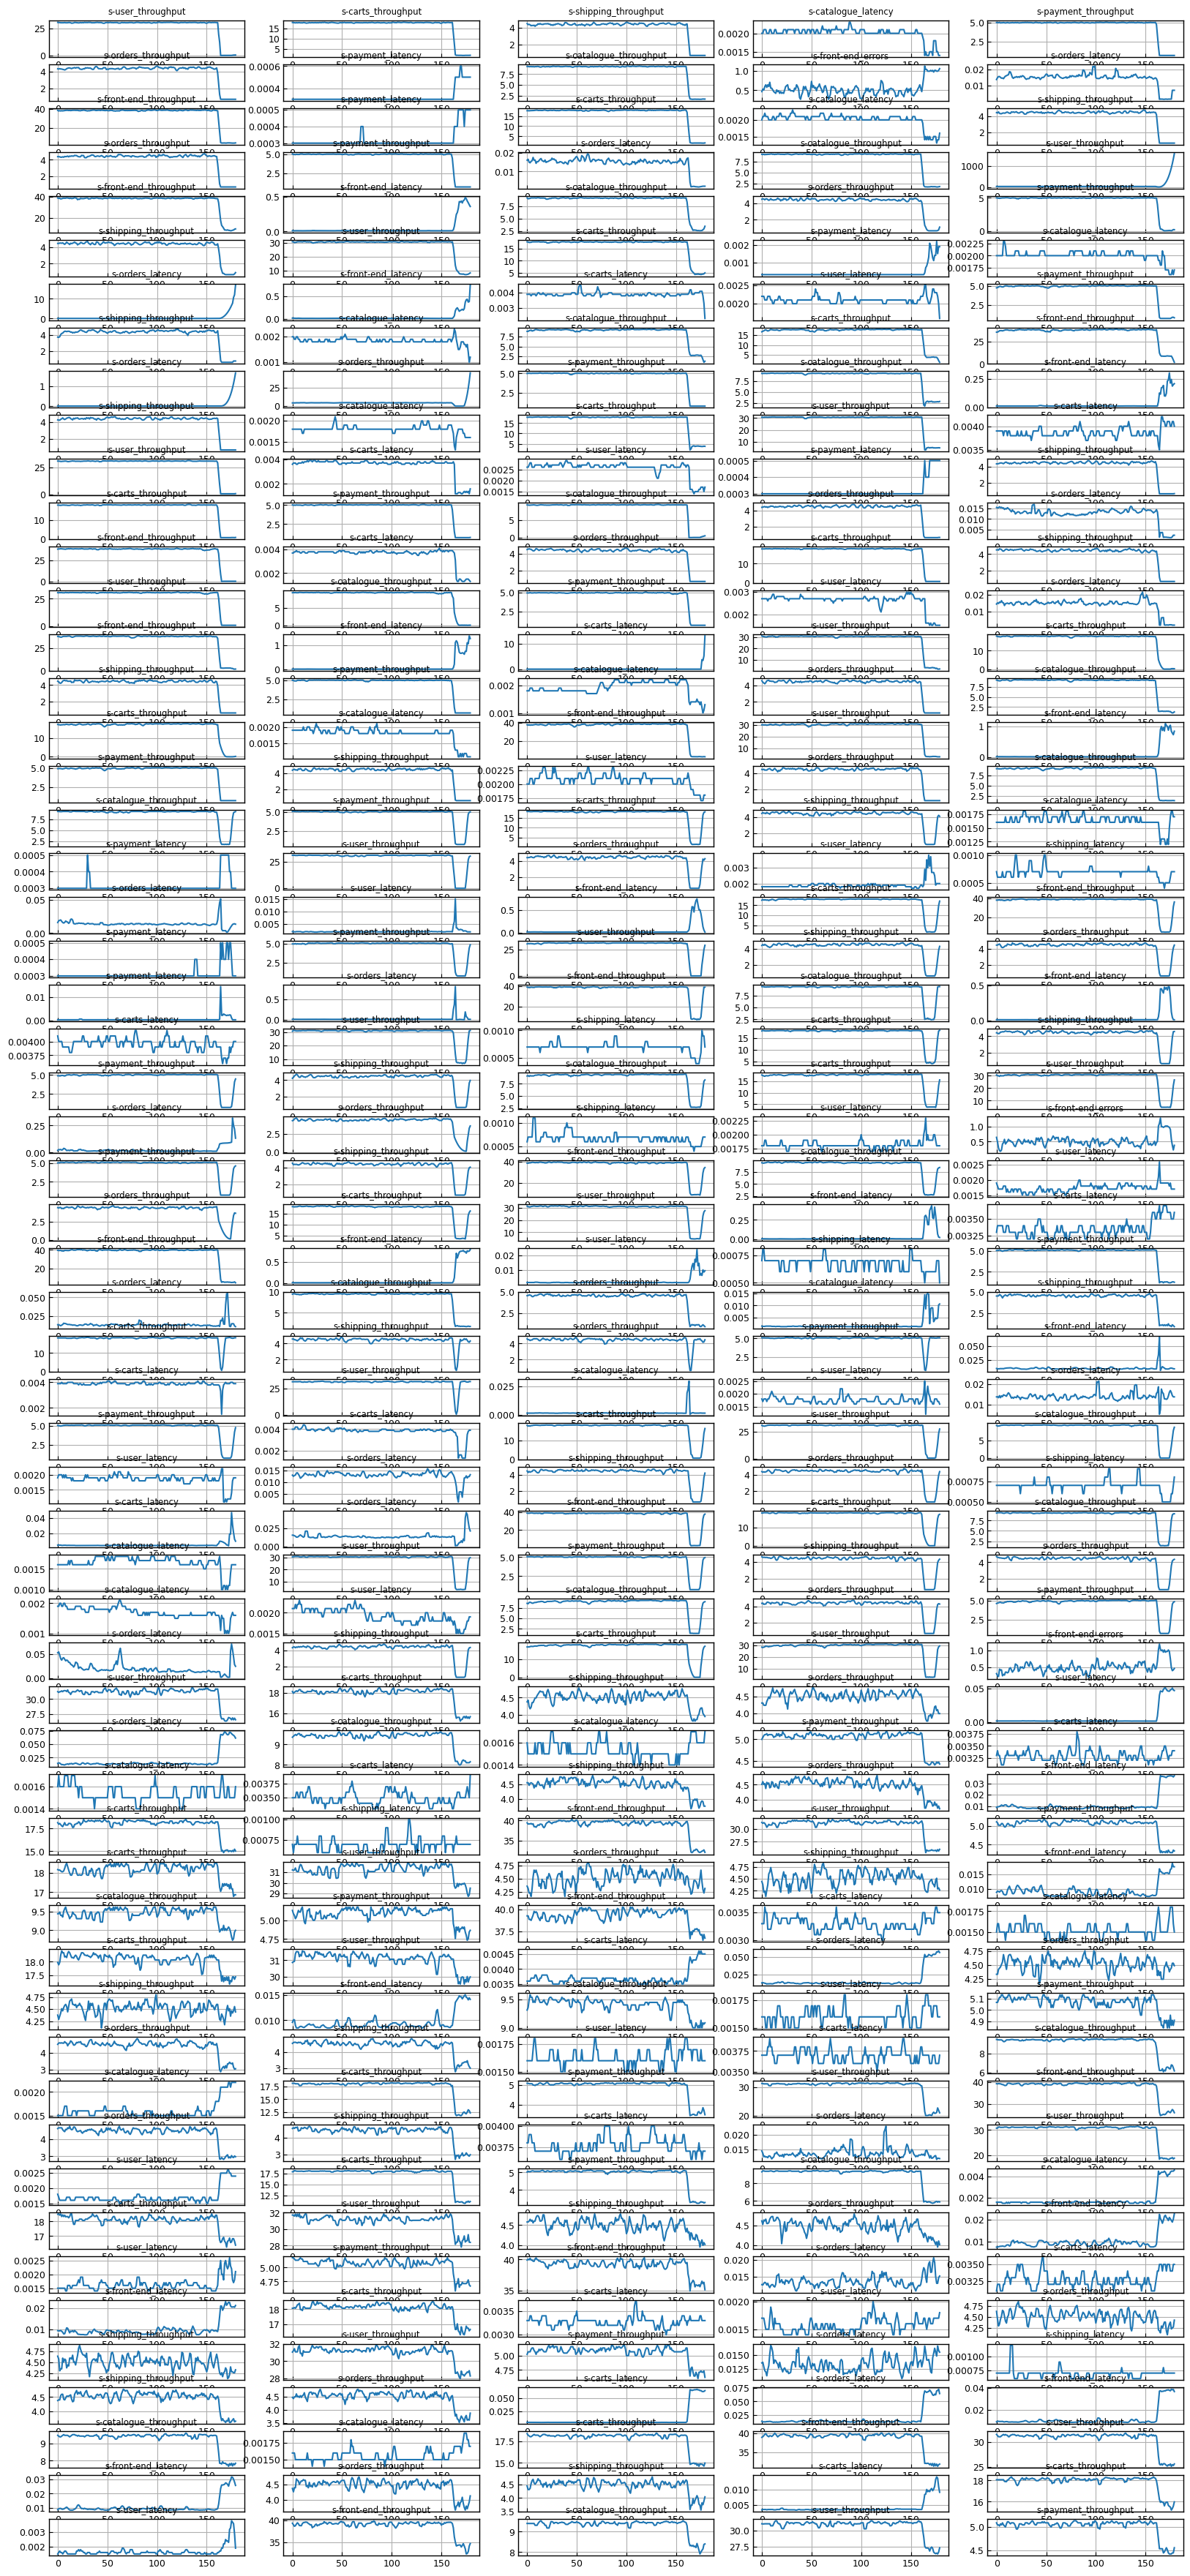

In [20]:
## Visualize
_df = _ranked_df.sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"]).head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
fig = plt.figure(figsize=(20, 45))
axs = fig.subplots(nrows=math.ceil(_df.shape[0] / 5), ncols=5)
for ax, row in zip(axs.flatten(), _df.itertuples()):
    ax.plot(row.time_series)
    ax.set_title(row.metric)

## Anomaly degree + FluxInfer

In [21]:
MIN_P: float = 0.0001

def score_multiplied_by_anomaly_degree(x: pd.Series) -> np.ndarray:
    P = x["anomaly_degree"]  # anomaly degree (normalize to [0, 1])
    score = x["rank"]
    # return score * (-np.log2(max([P, MIN_P])))
    return score * P

# from sklearn.preprocessing import minmax_scale

# def _minmax_scale(X):
#     # X_ = np.atleast_2d(X)
#     nz = minmax_scale(X, feature_range=(0, 1))
#     # reverse nz
#     return pd.DataFrame(1-nz, X.index)

from tsdr.outlierdetection.residual_integral import residual_integral_max

ranked_df_max_cluster["anomaly_degree"] = ranked_df_max_cluster.apply(lambda x: residual_integral_max(x.time_series, bkp=0)[0], axis=1)
# ranked_df_max_cluster["anomaly_degree"] = ranked_df_max_cluster.groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])["anomaly_degree"].apply(_minmax_scale)
ranked_df_max_cluster["anomaly_based_pagerank"] = ranked_df_max_cluster.apply(score_multiplied_by_anomaly_degree, axis=1)

_sorted_results_df = ranked_df_max_cluster.query("not metric.str.startswith('n-')", engine='python').loc[:, ranked_df.columns != "time_series"].dropna(subset=["rank"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "anomaly_based_pagerank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
# with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
#     display(_sorted_results_df.head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None, "display.precision", 2):
    display(
        pd.concat([
            evaluate_ac_of_rc(_sorted_results_df, pk, k=10, granuallity="metric"),
            evaluate_ac_of_rc(_sorted_results_df, pk, k=10, granuallity="container"),
            evaluate_ac_of_rc(_sorted_results_df, pk, k=10, granuallity="service"),
        ], axis=1)
    )

no cause metrics: qknmc, sock-shop, pod-memory-hog, catalogue
no cause metrics: qknmc, sock-shop, pod-memory-hog, orders
no cause metrics: qknmc, sock-shop, pod-memory-hog, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, catalogue
no cause metrics: qknmc, sock-shop, pod-network-loss, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, user-db


AC@K (metric)  AVG@K (metric)  AC@K (container)  AVG@K (container)  \
1            0.22            0.22              0.34               0.34   
2            0.39            0.30              0.55               0.45   
3            0.39            0.33              0.62               0.51   
4            0.39            0.35              0.76               0.57   
5            0.43            0.37              0.86               0.63   
6            0.43            0.38              0.93               0.68   
7            0.43            0.39              0.97               0.72   
8            0.43            0.39              0.97               0.75   
9            0.43            0.40              1.00               0.78   
10           0.48            0.40              1.00               0.80   

    AC@K (service)  AVG@K (service)  
1             0.45             0.45  
2             0.62             0.53  
3             0.76             0.61  
4             0.93             0.69  
5             0.93             0.74  
6             0.93             0.77  
7             1.00             0.80  
8             1.00             0.83  
9             1.00             0.85  
10            1.00             0.86

## WUDG + directed edges based network dependencies + PageRank

In [22]:
_list_of_records = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_wudg_and_pagerank)(record, reduced_df, init_graph_type="nw_call", directed_edge=True) for record, _, _, reduced_df in datasets_fluxrank_max_cluster)
ranked_datasets_directed = sum(_list_of_records, [])  # flatten

ranked_df = pd.DataFrame(ranked_datasets_directed, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp", "metric", "time_series", "rank"])
sorted_results_df_directed = ranked_df.query("not metric.str.startswith('n-')", engine='python').loc[:, ranked_df.columns != "time_series"].dropna(subset=["rank"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank"], ascending=False).groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(sorted_results_df_directed.head(n=10).set_index(["dataset_id", "target_app", "chaos_type", "chaos_comp"]))
    
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None, "display.precision", 2):
    display(
        pd.concat([
            evaluate_ac_of_rc(sorted_results_df_directed, pk, k=10, granuallity="metric"),
            evaluate_ac_of_rc(sorted_results_df_directed, pk, k=10, granuallity="container"),
            evaluate_ac_of_rc(sorted_results_df_directed, pk, k=10, granuallity="service"),
        ], axis=1)
    )

/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_402435/3474398805.py:56: RuntimeWar

metric  \
dataset_id target_app chaos_type       chaos_comp                                                                                                           
qknmc      sock-shop  pod-network-loss user-db                                                                             c-user_cpu_usage_seconds_total   
                                       user-db                                                                     c-catalogue-db_cpu_usage_seconds_total   
                                       user-db                                                                        c-catalogue_cpu_usage_seconds_total   
                                       user-db                                                                               c-user-db_memory_usage_bytes   
                                       user-db                                                                         c-user-db_memory_working_set_bytes   
                                       user-db                                                                              c-user_cpu_user_seconds_total   
                                       user-db                                                                      c-catalogue-db_cpu_user_seconds_total   
                                       user-db                                                                          c-catalogue_cpu_cfs_periods_total   
                                       user-db                                                                        m-orders-db_mongodb_sys_cpu_idle_ms   
                                       user-db                                                                        m-orders-db_mongodb_sys_cpu_user_ms   
                                       user                                                                            c-carts-db_cpu_usage_seconds_total   
                                       user                                                                             c-carts-db_cpu_user_seconds_total   
                                       user                                                                              c-orders_cpu_usage_seconds_total   
                                       user                                                                                c-user_cpu_usage_seconds_total   
                                       user                                                                             c-user-db_cpu_usage_seconds_total   
                                       user                                                                             c-payment_cpu_usage_seconds_total   
                                       user                                                                               c-payment_cpu_cfs_periods_total   
                                       user                                                                               c-orders_cpu_user_seconds_total   
                                       user                                                                                 c-user_cpu_user_seconds_total   
                                       user                                                                              c-user-db_cpu_user_seconds_total   
                                       payment                                                           m-orders_java_lang_OperatingSystem_SystemCpuLoad   
                                       payment                                                                                       s-payment_throughput   
                                       payment                                                            m-carts_java_lang_OperatingSystem_SystemCpuLoad   
                                       payment                                                                        c-catalogue_cpu_usage_seconds_total   
                                       payment                   

no cause metrics: qknmc, sock-shop, pod-memory-hog, catalogue
no cause metrics: qknmc, sock-shop, pod-memory-hog, orders
no cause metrics: qknmc, sock-shop, pod-memory-hog, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, catalogue
no cause metrics: qknmc, sock-shop, pod-network-loss, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, user-db


AC@K (metric)  AVG@K (metric)  AC@K (container)  AVG@K (container)  \
1            0.04            0.04              0.24               0.24   
2            0.04            0.04              0.34               0.29   
3            0.04            0.04              0.55               0.38   
4            0.04            0.04              0.69               0.46   
5            0.13            0.06              0.76               0.52   
6            0.13            0.07              0.83               0.57   
7            0.13            0.08              0.83               0.61   
8            0.13            0.09              0.86               0.64   
9            0.13            0.09              0.90               0.67   
10           0.17            0.10              0.93               0.69   

    AC@K (service)  AVG@K (service)  
1             0.24             0.24  
2             0.52             0.38  
3             0.72             0.49  
4             0.90             0.59  
5             0.97             0.67  
6             1.00             0.72  
7             1.00             0.76  
8             1.00             0.79  
9             1.00             0.82  
10            1.00             0.83